<a href="https://colab.research.google.com/github/angeloken/Riset-I-smile/blob/main/riset_prediksi_listrik_ver_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
dfull = pd.read_excel('/content/drive/MyDrive/RISET I-SMILE/Data Device Full.xlsx')
dbar = pd.read_excel('/content/drive/MyDrive/RISET I-SMILE/Data Device Sisi Barat Gd Deli.xlsx')
dtim = pd.read_excel('/content/drive/MyDrive/RISET I-SMILE/Data Device Sisi Timur Gd Deli.xlsx')

In [4]:
#import important library
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import date
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [84]:
url_tr = 'https://drive.google.com/file/d/1jI7ukSaRReUFAUMeH2jDMJRhRd7AnWtk/view?usp=sharing'
path_tr = 'https://drive.google.com/uc?export=download&id='+url_tr.split('/')[-2]
train = pd.read_csv(path_tr)
url_tst = 'https://drive.google.com/file/d/1Wu56Cp5qDX9gPoPk5k5_zUTmV9u27aO-/view?usp=sharing'
path_tst = 'https://drive.google.com/uc?export=download&id='+url_tst.split('/')[-2]
test = pd.read_csv(path_tst)

In [5]:
df = pd.read_csv('/content/opsd_germany_daily.csv')

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2006-01-01 to 2017-12-31
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         4383 non-null   datetime64[ns]
 1   Consumption  4383 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 102.7 KB


In [6]:
df = df[['Date','Consumption']]

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df.set_index(df['Date'],inplace=True)


In [9]:
df=df.drop(['Date'],axis=1)

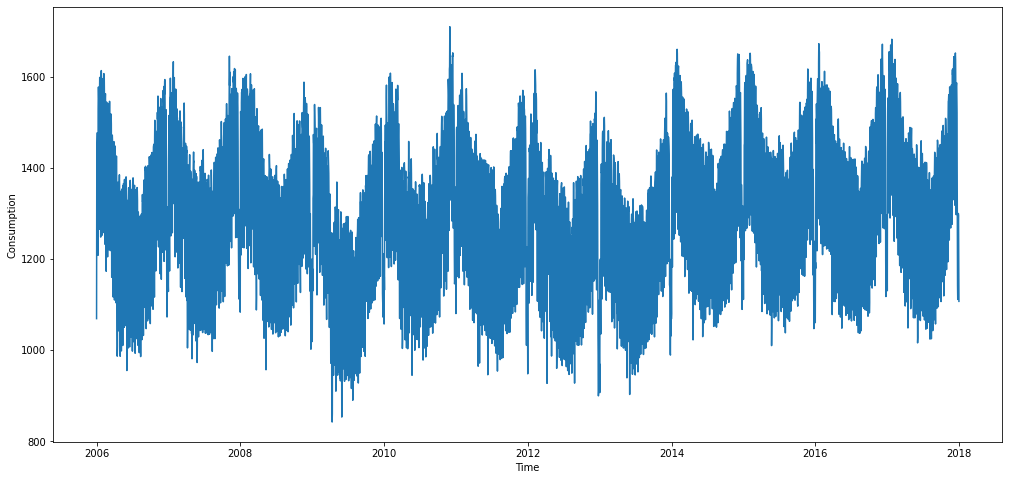

In [120]:
def plot_data(col):
    plt.figure(figsize=(17, 8))
    plt.plot(df[col])
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.grid(False)
    plt.show()
    
for col in df.columns:
    plot_data(col)

In [10]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

In [11]:
df = df.reset_index()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131


In [12]:
prediction_size = 30
train_df = df[:-prediction_size]

In [13]:
train_df

,ds,y
0,2006-01-01,1069.18400
1,2006-01-02,1380.52100
2,2006-01-03,1442.53300
3,2006-01-04,1457.21700
4,2006-01-05,1477.13100
...,...,...
4348,2017-11-27,1602.17797
4349,2017-11-28,1615.38061
4350,2017-11-29,1603.98435
4351,2017-11-30,1617.03309


In [14]:
m = Prophet()
m.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

In [16]:
future

,ds
0,2006-01-01
1,2006-01-02
2,2006-01-03
3,2006-01-04
4,2006-01-05
...,...
4378,2017-12-27
4379,2017-12-28
4380,2017-12-29
4381,2017-12-30


In [17]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds         yhat   yhat_lower   yhat_upper
0 2006-01-01  1036.099792   951.590508  1116.226092
1 2006-01-02  1331.945205  1252.739181  1414.293476
2 2006-01-03  1380.855928  1304.159115  1461.840476
3 2006-01-04  1397.816142  1317.372660  1473.811180
4 2006-01-05  1398.364070  1323.180000  1478.583808


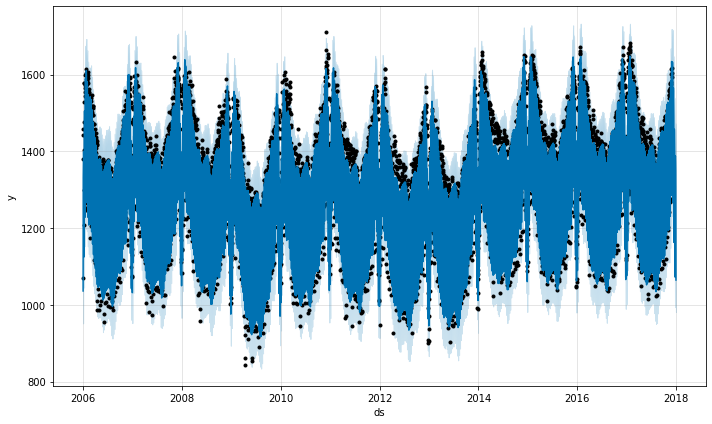

In [18]:
m.plot(forecast)
plt.show()

In [19]:
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [20]:
cmp_df = make_comparison_dataframe(df, forecast)

cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2006-01-01,1036.099792,951.590508,1116.226092,1069.184
2006-01-02,1331.945205,1252.739181,1414.293476,1380.521
2006-01-03,1380.855928,1304.159115,1461.840476,1442.533
2006-01-04,1397.816142,1317.372660,1473.811180,1457.217
2006-01-05,1398.364070,1323.180000,1478.583808,1477.131


In [21]:
def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [22]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 6.035705004403182
MAE 81.81595899989246


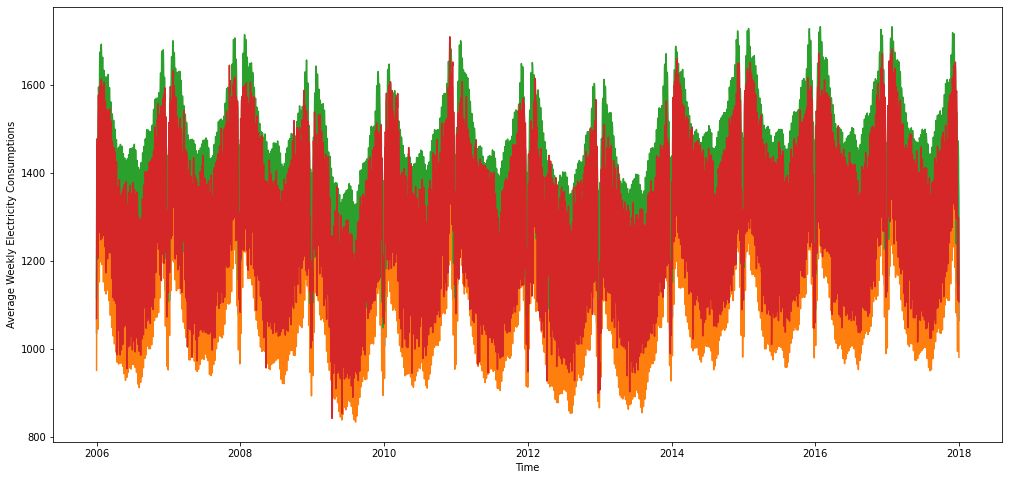

In [23]:
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Average Weekly Electricity Consumptions')
plt.grid(False)
plt.show()